# Constructing our Minimum-Covariance Portfolios

We will be constructing our portfolios by selecting the assets which have the lowest correlations between each other. We will rebalance semi-annually based on these selections, and at each rebalance, ensure that our portfolio is split among the two geographies 50/50 

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Risk_analytics

# Data Preprocessing

In [8]:
# Remove 1st line since they are pct changes, therefore have
# NaNs in the first row
rets = pd.read_csv("returns.csv")[1:]
rets.head()

,Date,USA_EWJ,USA_EWT,USA_MCHI,USA_EWY,USA_EWZ,USA_INDA,USA_ACWV,USA_IDV,USA_EWC,...,CAN_HULC.TO,CAN_HMUS.TO,CAN_HSUV.TO,USA_CNY=X,USA_BRL=X,USA_ZAR=X,USA_RUB=X,USA_EUR=X,USA_JPY=X,USA_MXN=X
1,2011-01-04,0.000804,-0.007407,NaN,0.002263,0.004396,NaN,NaN,-0.009259,-0.010412,...,NaN,NaN,NaN,-0.001760,0.019189,0.006326,0.0,0.000134,0.006743,-0.000384
2,2011-01-05,-0.007231,-0.016584,NaN,0.000376,-0.011616,NaN,NaN,-0.002596,0.002023,...,NaN,NaN,NaN,0.002584,0.012754,0.003853,0.0,0.002671,0.004506,-0.004249
3,2011-01-06,0.000000,-0.002108,NaN,-0.006960,-0.010049,NaN,NaN,-0.009891,-0.004847,...,NaN,NaN,NaN,-0.002956,0.004498,0.008670,0.0,0.012522,0.014030,0.003119
4,2011-01-07,0.003777,-0.015632,NaN,0.005493,-0.009119,NaN,NaN,-0.005258,0.000406,...,NaN,NaN,NaN,0.005929,0.006507,0.012983,0.0,0.013551,0.001334,0.000573
5,2011-01-10,0.000000,0.002146,NaN,-0.014883,-0.010071,NaN,NaN,0.000529,-0.003651,...,NaN,NaN,NaN,0.000151,-0.029895,-0.000295,0.0,0.006620,-0.003241,-0.001063


In [9]:
# Reindex to date
rets.index = pd.to_datetime(rets['Date'])
del rets['Date']
rets.head()

,USA_EWJ,USA_EWT,USA_MCHI,USA_EWY,USA_EWZ,USA_INDA,USA_ACWV,USA_IDV,USA_EWC,USA_EWU,...,CAN_HULC.TO,CAN_HMUS.TO,CAN_HSUV.TO,USA_CNY=X,USA_BRL=X,USA_ZAR=X,USA_RUB=X,USA_EUR=X,USA_JPY=X,USA_MXN=X
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-04,0.000804,-0.007407,NaN,0.002263,0.004396,NaN,NaN,-0.009259,-0.010412,0.010462,...,NaN,NaN,NaN,-0.001760,0.019189,0.006326,0.0,0.000134,0.006743,-0.000384
2011-01-05,-0.007231,-0.016584,NaN,0.000376,-0.011616,NaN,NaN,-0.002596,0.002023,-0.002157,...,NaN,NaN,NaN,0.002584,0.012754,0.003853,0.0,0.002671,0.004506,-0.004249
2011-01-06,0.000000,-0.002108,NaN,-0.006960,-0.010049,NaN,NaN,-0.009891,-0.004847,-0.008647,...,NaN,NaN,NaN,-0.002956,0.004498,0.008670,0.0,0.012522,0.014030,0.003119
2011-01-07,0.003777,-0.015632,NaN,0.005493,-0.009119,NaN,NaN,-0.005258,0.000406,-0.003925,...,NaN,NaN,NaN,0.005929,0.006507,0.012983,0.0,0.013551,0.001334,0.000573
2011-01-10,0.000000,0.002146,NaN,-0.014883,-0.010071,NaN,NaN,0.000529,-0.003651,0.001751,...,NaN,NaN,NaN,0.000151,-0.029895,-0.000295,0.0,0.006620,-0.003241,-0.001063


In [10]:
# Delete any outliers
rets[rets > 1] = 0
rets[rets < -1] = 0

In [11]:
sum(rets["USA_RUB=X"] > 100)

0

In [12]:
rets.index

DatetimeIndex(['2011-01-04', '2011-01-05', '2011-01-06', '2011-01-07',
               '2011-01-10', '2011-01-11', '2011-01-12', '2011-01-13',
               '2011-01-14', '2011-01-17',
               ...
               '2021-06-22', '2021-06-23', '2021-06-24', '2021-06-25',
               '2021-06-28', '2021-06-29', '2021-06-30', '2021-07-01',
               '2021-07-02', '2021-07-05'],
              dtype='datetime64[ns]', name='Date', length=2740, freq=None)

In [13]:
# read the risk free rate
riskfree = pd.read_csv("3mTbill.csv")
riskfree['Date'] = pd.to_datetime(riskfree['Date'])
riskfree.head()

,Date,RFR
0,2010-01-01,0.061
1,2010-01-04,0.060
2,2010-01-05,0.066
3,2010-01-06,0.054
4,2010-01-07,0.049


In [14]:
riskfree

,Date,RFR
0,2010-01-01,0.061
1,2010-01-04,0.060
2,2010-01-05,0.066
3,2010-01-06,0.054
4,2010-01-07,0.049
...,...,...
3001,2021-07-05,0.044
3002,2021-07-06,0.047
3003,2021-07-07,0.048
3004,2021-07-08,0.048


In [15]:
# match the date
riskfree = riskfree[riskfree['Date'].isin(rets.index.values)].set_index('Date')
riskfree.head()

,RFR
Date,
2011-01-04,0.140
2011-01-05,0.140
2011-01-06,0.145
2011-01-07,0.140
2011-01-10,0.140


In [16]:
# daily risk free
riskfree = (1 + riskfree).pow(1/252) - 1
riskfree.head()

,RFR
Date,
2011-01-04,0.000520
2011-01-05,0.000520
2011-01-06,0.000537
2011-01-07,0.000520
2011-01-10,0.000520


In [17]:
len(riskfree.index) == len(rets.index)

True

In [18]:
# Create a list of semiannual dates to split on
dates_to_split = pd.date_range(rets.index[0], rets.index[-1], freq='6M')
dates_to_split

DatetimeIndex(['2011-01-31', '2011-07-31', '2012-01-31', '2012-07-31',
               '2013-01-31', '2013-07-31', '2014-01-31', '2014-07-31',
               '2015-01-31', '2015-07-31', '2016-01-31', '2016-07-31',
               '2017-01-31', '2017-07-31', '2018-01-31', '2018-07-31',
               '2019-01-31', '2019-07-31', '2020-01-31', '2020-07-31',
               '2021-01-31'],
              dtype='datetime64[ns]', freq='6M')

In [19]:
# Split on these dates
semiannual = {}

for i in range(len(dates_to_split)-1):
    #print(dates_to_split[i+1])
    semiannual[i] = rets[dates_to_split[i]:dates_to_split[i+1]]

In [20]:
# Sanity check
print(semiannual[0].index[0],semiannual[0].index[-1])

2011-01-31 00:00:00 2011-07-29 00:00:00


In [21]:
# Sanity check
print(semiannual[1].index[0],semiannual[1].index[-1])

2011-08-01 00:00:00 2012-01-31 00:00:00


In [22]:
# Sanity check
print(semiannual[19].index[0],semiannual[19].index[-1])

2020-07-31 00:00:00 2021-01-29 00:00:00


# Lowest correlation Search

In [23]:
# For each group of 6mo, find the assets with lowest avg correlation
corrs = semiannual[10].corr().abs().mean(axis=1)
corrs

USA_EWJ      0.435156
USA_EWT      0.511699
USA_MCHI     0.528725
USA_EWY      0.541586
USA_EWZ      0.432182
               ...   
USA_ZAR=X    0.118197
USA_RUB=X    0.084428
USA_EUR=X    0.151444
USA_JPY=X    0.082320
USA_MXN=X    0.462142
Length: 128, dtype: float64

In [24]:
# Sort those values to see which ones have lowest correlation
corrs.sort_values(axis=0)[:30]

CAN_XFR.TO    0.075507
CAN_CMR.TO    0.081464
USA_JPY=X     0.082320
USA_RUB=X     0.084428
USA_BRL=X     0.085703
CAN_HXQ.TO    0.097759
CAN_HHF.TO    0.113232
CAN_CBO.TO    0.113303
USA_ZAR=X     0.118197
USA_CNY=X     0.120320
CAN_HUZ.TO    0.144101
USA_EUR=X     0.151444
CAN_XSC.TO    0.154957
CAN_SVR.TO    0.162192
CAN_HXF.TO    0.165272
CAN_XGD.TO    0.181217
CAN_HUN.TO    0.185430
CAN_XIG.TO    0.186638
CAN_CVD.TO    0.190808
USA_KSA       0.198407
CAN_CBH.TO    0.199100
CAN_HUG.TO    0.208522
CAN_HTB.TO    0.237717
CAN_XUU.TO    0.248717
CAN_CGL.TO    0.253634
CAN_CLF.TO    0.280254
CAN_CGR.TO    0.283629
CAN_CLG.TO    0.284980
CAN_HXE.TO    0.285884
USA_QAT       0.286492
dtype: float64

In [25]:
# First 15 CAN values
[x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:15]

['CAN_XFR.TO',
 'CAN_CMR.TO',
 'CAN_HXQ.TO',
 'CAN_HHF.TO',
 'CAN_CBO.TO',
 'CAN_HUZ.TO',
 'CAN_XSC.TO',
 'CAN_SVR.TO',
 'CAN_HXF.TO',
 'CAN_XGD.TO',
 'CAN_HUN.TO',
 'CAN_XIG.TO',
 'CAN_CVD.TO',
 'CAN_CBH.TO',
 'CAN_HUG.TO']

In [26]:
# Loop through each semiannual period, save the 10, 15 or 30 Canadian and USA assets with the
# lowest average correlation
top10 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top10[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:10]
    top10[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:10]

top15 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top15[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:15]
    top15[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:15]

top30 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top30[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:30]
    top30[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:30]

In [27]:
# We only need the index
top30[1]

['USA_JPY=X',
 'USA_ZAR=X',
 'USA_RUB=X',
 'USA_BRL=X',
 'USA_EUR=X',
 'USA_CNY=X',
 'USA_EPU',
 'USA_TUR',
 'USA_EPHE',
 'USA_ECH',
 'USA_EWJ',
 'USA_THD',
 'USA_EIRL',
 'USA_EIDO',
 'USA_MCHI',
 'USA_EIS',
 'USA_EWZ',
 'USA_EWH',
 'USA_ERUS',
 'USA_MXN=X',
 'USA_ENZL',
 'USA_EWL',
 'USA_EWT',
 'USA_EWW',
 'USA_EWY',
 'USA_EWM',
 'USA_EWP',
 'USA_EWS',
 'USA_EPOL',
 'USA_EZA',
 'CAN_CMR.TO',
 'CAN_HUN.TO',
 'CAN_CVD.TO',
 'CAN_CGL.TO',
 'CAN_HUG.TO',
 'CAN_XIG.TO',
 'CAN_CGR.TO',
 'CAN_DLR.TO',
 'CAN_XGD.TO',
 'CAN_HUC.TO',
 'CAN_CBO.TO',
 'CAN_CHB.TO',
 'CAN_HUZ.TO',
 'CAN_SVR.TO',
 'CAN_CWW.TO',
 'CAN_CLF.TO',
 'CAN_XPF.TO',
 'CAN_HXS.TO',
 'CAN_COW.TO',
 'CAN_XHY.TO',
 'CAN_HXT.TO',
 'CAN_XUU.TO',
 'CAN_XDG.TO',
 'CAN_XBM.TO',
 'CAN_XDGH.TO',
 'CAN_XGGB.TO',
 'CAN_CLG.TO',
 'CAN_CBH.TO',
 'CAN_XSE.TO',
 'CAN_XFR.TO']

# Equally-weighted portfolio

In [28]:
# Let's create a one-period example before looping through them all, start
# with 100k capital
capital = 100000

In [29]:
# Use previous period's lowest corrs to construct portfolio
# for current period
returns = semiannual[1][top30[1]]
returns

,USA_JPY=X,USA_ZAR=X,USA_RUB=X,USA_BRL=X,USA_EUR=X,USA_CNY=X,USA_EPU,USA_TUR,USA_EPHE,USA_ECH,...,CAN_HXT.TO,CAN_XUU.TO,CAN_XDG.TO,CAN_XBM.TO,CAN_XDGH.TO,CAN_XGGB.TO,CAN_CLG.TO,CAN_CBH.TO,CAN_XSE.TO,CAN_XFR.TO
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-01,-0.006651,-0.007357,0.002785,-0.010430,-0.002150,-0.002219,0.005180,-0.006188,0.009129,0.020165,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-02,0.003199,0.008252,0.004507,0.007307,0.007182,-0.000482,-0.027197,-0.030212,-0.015625,-0.027369,...,-0.017975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-03,-0.001614,0.010074,0.003179,0.003531,0.006275,0.000560,-0.012655,0.021165,0.000835,-0.013722,...,0.006744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-04,-0.002884,-0.010607,-0.000783,-0.000192,-0.012613,-0.000342,-0.054844,-0.081509,-0.035476,-0.054244,...,-0.031579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-05,0.028245,0.032729,0.014975,0.008829,0.020382,0.000124,-0.005046,-0.038793,0.000000,-0.021043,...,-0.016798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-01-25,0.008922,0.002244,-0.002271,0.003653,-0.001042,0.001267,0.022340,0.020039,-0.001661,-0.003078,...,0.011605,NaN,NaN,0.026786,NaN,NaN,NaN,NaN,NaN,-0.001115
2012-01-26,0.001068,-0.009787,-0.010080,0.000910,-0.005086,-0.001345,0.015814,0.019918,-0.011231,0.004245,...,-0.008604,NaN,NaN,-0.003953,NaN,NaN,NaN,NaN,NaN,0.000000
2012-01-27,-0.003986,-0.006987,-0.004352,0.052557,0.001180,0.003247,0.001981,0.027822,0.020194,0.005573,...,0.002893,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000


In [30]:
# Save the sum of the dollar returns, add to capital
capital += returns.cumsum().iloc[-1,:].sum()
capital

99998.90786344971

In [31]:
returns.columns

Index(['USA_JPY=X', 'USA_ZAR=X', 'USA_RUB=X', 'USA_BRL=X', 'USA_EUR=X',
       'USA_CNY=X', 'USA_EPU', 'USA_TUR', 'USA_EPHE', 'USA_ECH', 'USA_EWJ',
       'USA_THD', 'USA_EIRL', 'USA_EIDO', 'USA_MCHI', 'USA_EIS', 'USA_EWZ',
       'USA_EWH', 'USA_ERUS', 'USA_MXN=X', 'USA_ENZL', 'USA_EWL', 'USA_EWT',
       'USA_EWW', 'USA_EWY', 'USA_EWM', 'USA_EWP', 'USA_EWS', 'USA_EPOL',
       'USA_EZA', 'CAN_CMR.TO', 'CAN_HUN.TO', 'CAN_CVD.TO', 'CAN_CGL.TO',
       'CAN_HUG.TO', 'CAN_XIG.TO', 'CAN_CGR.TO', 'CAN_DLR.TO', 'CAN_XGD.TO',
       'CAN_HUC.TO', 'CAN_CBO.TO', 'CAN_CHB.TO', 'CAN_HUZ.TO', 'CAN_SVR.TO',
       'CAN_CWW.TO', 'CAN_CLF.TO', 'CAN_XPF.TO', 'CAN_HXS.TO', 'CAN_COW.TO',
       'CAN_XHY.TO', 'CAN_HXT.TO', 'CAN_XUU.TO', 'CAN_XDG.TO', 'CAN_XBM.TO',
       'CAN_XDGH.TO', 'CAN_XGGB.TO', 'CAN_CLG.TO', 'CAN_CBH.TO', 'CAN_XSE.TO',
       'CAN_XFR.TO'],
      dtype='object')

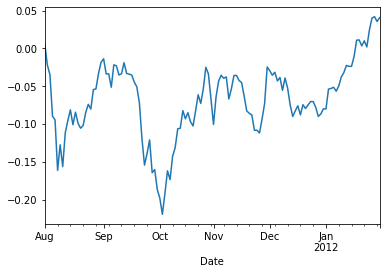

In [32]:
# Sanity check to make sure calculation is correct
returns['USA_EPU'].cumsum().plot()

In [33]:
# Reallocate capital and rebalance
position_size = capital / 60
position_size

1666.6484643908286

In [34]:
# Use new allocations to calculate next period
returns2 = semiannual[2][top30[2]] * position_size
returns2

,USA_CNY=X,USA_JPY=X,USA_RUB=X,USA_BRL=X,USA_ZAR=X,USA_EUR=X,USA_KXI,USA_ACWV,USA_MXN=X,USA_EPHE,...,CAN_XHY.TO,CAN_HXT.TO,CAN_XBM.TO,CAN_XUU.TO,CAN_XDG.TO,CAN_XDGH.TO,CAN_XGGB.TO,CAN_CLG.TO,CAN_CBH.TO,CAN_XSE.TO
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-31,-2.740851,-8.079983,13.083646,7.959253,18.251904,8.805434,-2.534827,0.790818,11.019015,25.986512,...,2.763928,-1.605634,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-01,-1.319888,-1.964358,-16.573130,-1.431583,-7.749675,7.883241,16.501470,15.413633,-21.535632,42.184878,...,2.759352,6.428731,10.700793,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-02,-0.475536,-1.770008,4.270869,-12.513236,-27.763928,-11.769193,-1.885349,1.566399,-12.163995,28.328303,...,1.377395,4.803022,14.619723,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-03,-0.687082,-0.196877,1.847824,-13.089114,-5.307521,4.170462,14.470711,7.824641,-17.285152,8.621739,...,2.752516,4.789220,18.445121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-06,0.105748,8.116652,0.817889,-2.716149,-21.123333,1.313701,-3.742474,-12.460923,0.658609,-3.958785,...,0.000000,-3.183665,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-07-25,0.391471,-4.341616,15.288337,7.447702,12.242592,8.688880,0.000000,7.577397,-13.312277,4.907320,...,-4.012797,3.432850,-3.638970,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
2012-07-26,0.260919,-0.085352,-13.387345,-10.429284,-22.016880,-10.855026,40.103360,20.743531,-24.155036,23.241336,...,16.089929,22.267657,12.764266,NaN,NaN,NaN,NaN,-4.365811,-2.276842,NaN
2012-07-27,-1.173953,4.715943,-18.977759,-10.330974,-30.720625,-19.019662,24.763609,18.253414,-21.301922,20.508884,...,7.968040,16.903128,54.288224,NaN,NaN,NaN,NaN,-6.565916,-7.979849,NaN


In [35]:
# Concatenate to get continuous stream
pd.concat([returns, returns2])

,USA_JPY=X,USA_ZAR=X,USA_RUB=X,USA_BRL=X,USA_EUR=X,USA_CNY=X,USA_EPU,USA_TUR,USA_EPHE,USA_ECH,...,CAN_XDGH.TO,CAN_XGGB.TO,CAN_CLG.TO,CAN_CBH.TO,CAN_XSE.TO,CAN_XFR.TO,USA_KXI,USA_ACWV,USA_IXJ,USA_EWI
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-01,-0.006651,-0.007357,0.002785,-0.010430,-0.002150,-0.002219,0.005180,-0.006188,0.009129,0.020165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-02,0.003199,0.008252,0.004507,0.007307,0.007182,-0.000482,-0.027197,-0.030212,-0.015625,-0.027369,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-03,-0.001614,0.010074,0.003179,0.003531,0.006275,0.000560,-0.012655,0.021165,0.000835,-0.013722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-04,-0.002884,-0.010607,-0.000783,-0.000192,-0.012613,-0.000342,-0.054844,-0.081509,-0.035476,-0.054244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-05,0.028245,0.032729,0.014975,0.008829,0.020382,0.000124,-0.005046,-0.038793,0.000000,-0.021043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-07-25,-4.341616,12.242592,15.288337,7.447702,8.688880,0.391471,-5.475846,23.005254,4.907320,-3.213126,...,NaN,NaN,0.000000,0.000000,NaN,0.9208,0.000000,7.577397,9.215276,37.904479
2012-07-26,-0.085352,-22.016880,-13.387345,-10.429284,-10.855026,0.260919,17.980025,66.860442,23.241336,-5.472865,...,NaN,NaN,-4.365811,-2.276842,NaN,0.0000,40.103360,20.743531,24.220736,108.938613
2012-07-27,4.715943,-30.720625,-18.977759,-10.330974,-19.019662,-1.173953,24.211614,38.958590,20.508884,19.702627,...,NaN,NaN,-6.565916,-7.979849,NaN,0.0000,24.763609,18.253414,30.326163,80.117194


# Portfolio weight optimization -- MVO, Risk Parity and Sharpe Ratio Maximization results

In [102]:
import warnings
warnings.filterwarnings('ignore')

import portfolio_optimizer

from importlib import reload
reload(portfolio_optimizer)

from portfolio_optimizer import portfolio_optimizer

In [103]:
# Risk mapping Parameter
VaRcutoff = {'VaR95':1100,'VaR99':1800,'CVaR95':2700,'CVaR99':4400}

10 cutoff ETFs

In [104]:
opt10 = portfolio_optimizer(semiannual)





# MVO:
pct_full_portfolio_mvo, dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo = opt10.portfolio_simulator(100000, riskfree, top10, 10,VaRcutoff, 'MVO')
# Risk parity
pct_full_portfolio_rp, dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt10.portfolio_simulator(100000, riskfree, top10, 10,VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
pct_full_portfolio_sr, dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt10.portfolio_simulator(100000, riskfree, top10, 10,VaRcutoff, 'Sharpe ratio maximization')

Max drawdown: -331.4465391578136%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-776.368629,-1273.524510,-1075.570021,-1520.118875
3,-592.911377,-762.659293,-710.189903,-890.404912
4,-527.265502,-791.549418,-679.418176,-855.962071
5,-474.871692,-613.509215,-554.398094,-632.467378
6,-406.996986,-467.255459,-464.584491,-548.539067
7,-1099.591010,-1643.069206,-1467.343003,-1687.536613
8,-614.381841,-953.274138,-813.511663,-1111.699002
9,-990.741369,-1665.195199,-1987.836996,-4088.847749
10,-561.056550,-906.046705,-796.529686,-1148.912097


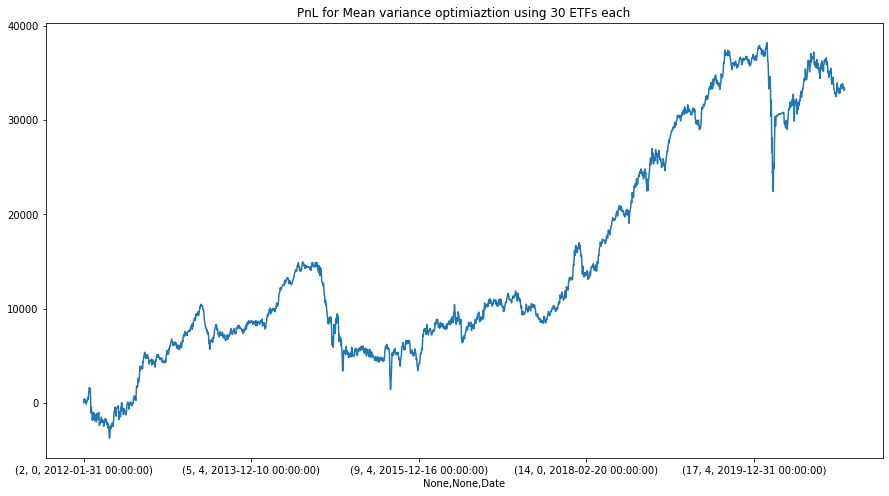

In [105]:
pd.concat(PnL_mvo).cumsum().plot(figsize=(15,8))
plt.title('PnL for Mean variance optimiaztion using 30 ETFs each')
print(f'Max drawdown: {max_drawdown_mvo}')
overallrisk_mvo

Max drawdown: -331.4455009206793%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-776.366403,-1273.520597,-1075.567012,-1520.114222
3,-592.911100,-762.658769,-710.189476,-890.404453
4,-527.265383,-791.549183,-679.418074,-855.961967
5,-474.871534,-613.508917,-554.397744,-632.466944
6,-406.997007,-467.255425,-464.584482,-548.539027
7,-1099.589916,-1643.068630,-1467.342152,-1687.535742
8,-614.381694,-953.274168,-813.511565,-1111.698773
9,-990.741329,-1665.195384,-1987.836477,-4088.846147
10,-561.057315,-906.045589,-796.529328,-1148.911554


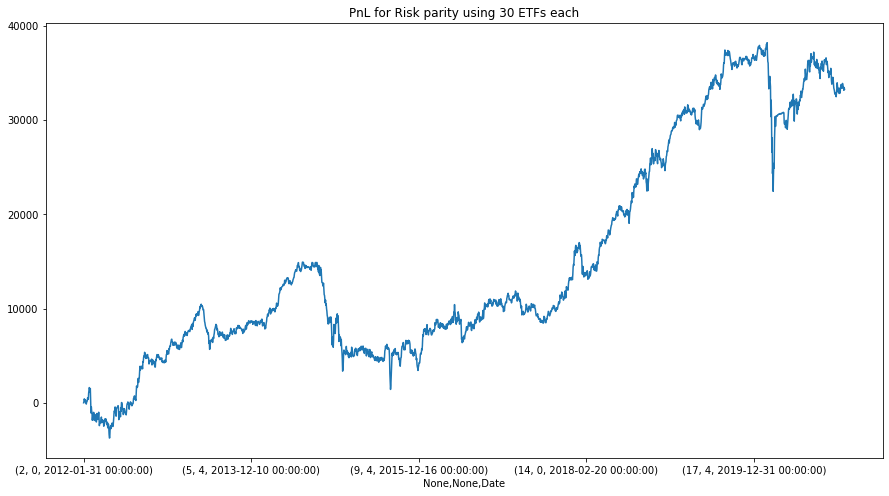

In [106]:
pd.concat(PnL_rp).cumsum().plot(figsize=(15,8))
plt.title('PnL for Risk parity using 30 ETFs each')
print(f'Max drawdown: {max_drawdown_rp}')
overallrisk_rp

Max drawdown: -129.51057094219533%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-445.681032,-727.936055,-620.899964,-853.771672
3,-611.818425,-801.571670,-735.761471,-882.108307
4,-739.262526,-1102.216988,-944.953117,-1191.442014
5,-811.001007,-1561.264057,-1230.914290,-1713.586877
6,-692.439742,-1028.896454,-902.377090,-1137.503458
7,-1322.212441,-2334.661472,-1882.327579,-2517.147484
8,-706.613017,-1135.886182,-960.779540,-1267.033088
9,-1263.983284,-2724.485339,-1877.341328,-2952.416779
10,-1518.537566,-2003.078262,-1883.534704,-2366.423177


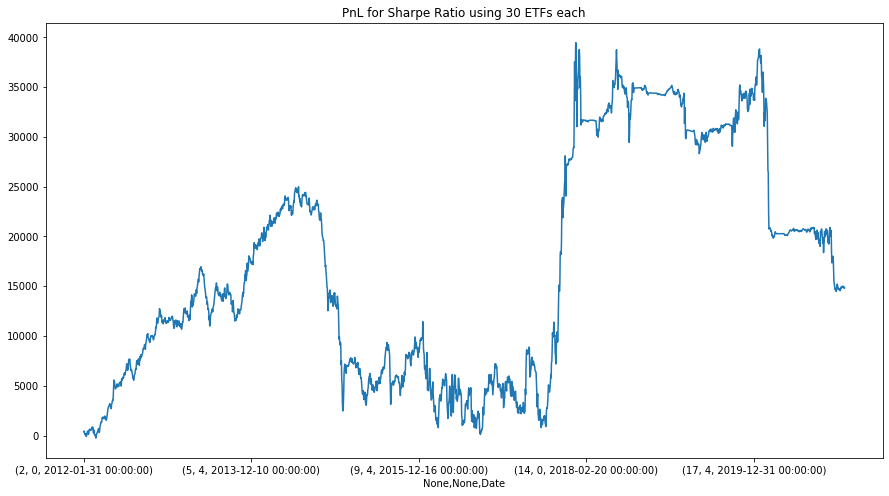

In [107]:
pd.concat(PnL_sr).cumsum().plot(figsize=(15,8))
plt.title('PnL for Sharpe Ratio using 30 ETFs each')
print(f'Max drawdown: {max_drawdown_sr}')
overallrisk_sr

Text(0.5, 1.0, 'For Risk parity using 10 ETFs each')

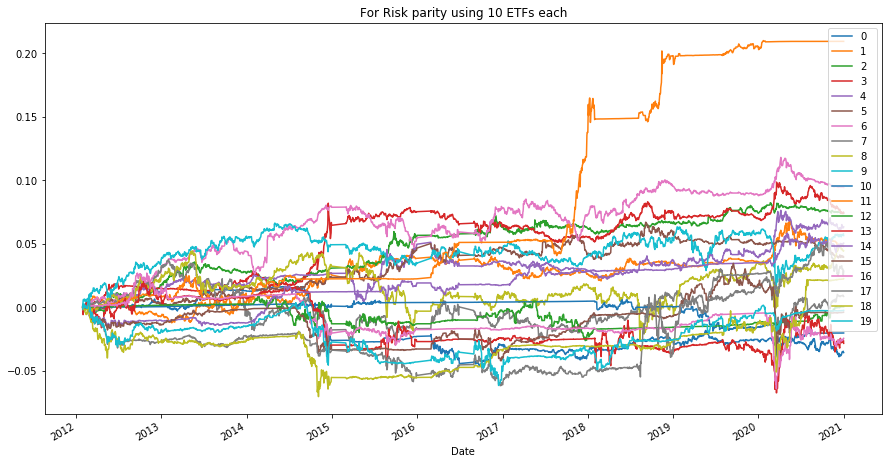

In [108]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.title('For Risk parity using 10 ETFs each')

Text(0.5, 1.0, 'For Risk parity using 10 ETFs each')

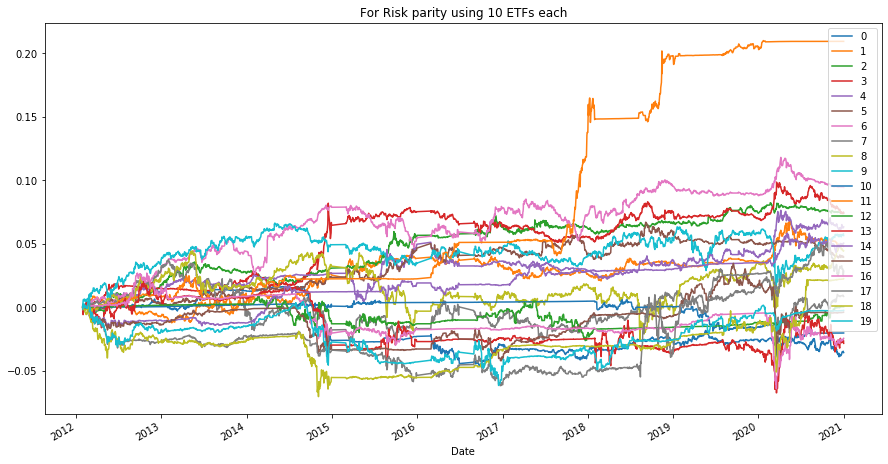

In [109]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.title('For Risk parity using 10 ETFs each')

Text(0.5, 1.0, 'For Sharpe Ratio Maximization using 10 ETFs each')

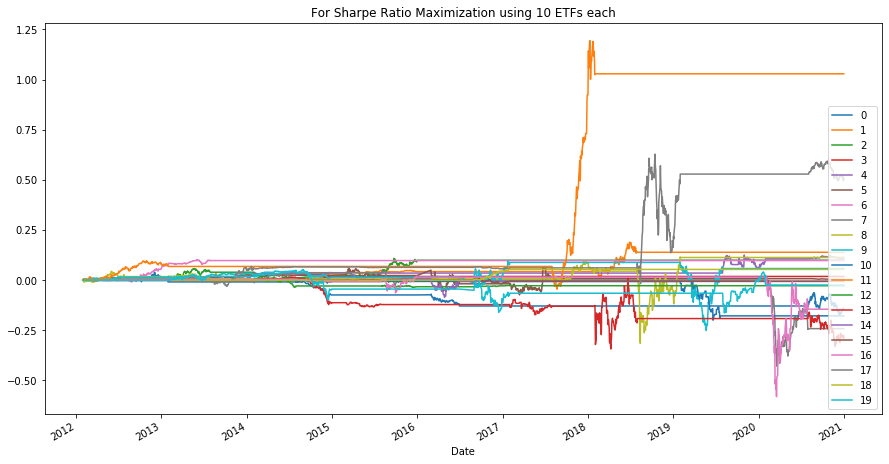

In [110]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.title('For Sharpe Ratio Maximization using 10 ETFs each')

15 cutoff ETFs

In [111]:
opt15 = portfolio_optimizer(semiannual)

# MVO:
pct_full_portfolio_mvo, dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo = opt15.portfolio_simulator(100000, riskfree, top15, 15,VaRcutoff, 'MVO')
# Risk parity
pct_full_portfolio_rp, dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt15.portfolio_simulator(100000, riskfree, top15, 15,VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
pct_full_portfolio_sr, dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt15.portfolio_simulator(100000, riskfree, top15, 15,VaRcutoff, 'Sharpe ratio maximization')

Max drawdown: -257.05127457486776%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-840.399448,-1299.023421,-1097.031305,-1403.365446
3,-534.099509,-779.776816,-707.653139,-887.410976
4,-687.608092,-1521.520830,-1064.115188,-1616.862016
5,-677.763049,-1020.372409,-875.701816,-1120.000890
6,-430.977848,-515.759602,-514.370095,-671.676383
7,-959.567127,-1430.448941,-1264.414461,-1560.738717
8,-787.457455,-1137.744980,-1038.797375,-1205.385232
9,-1045.591000,-2290.274298,-1749.257258,-3329.706520
10,-794.220458,-1231.776545,-1134.505320,-1745.687746


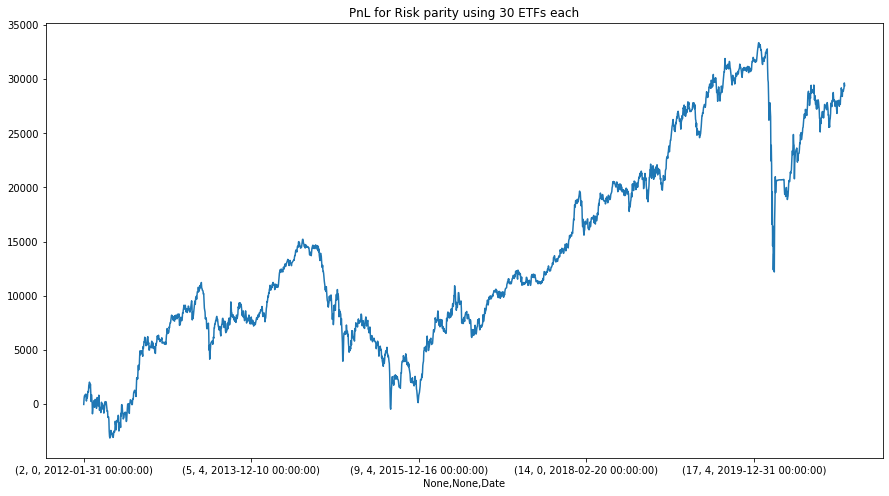

In [112]:
pd.concat(PnL_mvo).cumsum().plot(figsize=(15,8))
plt.title('PnL for Risk parity using 30 ETFs each')
print(f'Max drawdown: {max_drawdown_mvo}')
overallrisk_mvo

Max drawdown: -257.0502410126008%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-840.395599,-1299.017198,-1097.026379,-1403.358563
3,-534.098372,-779.775844,-707.652031,-887.409688
4,-687.607730,-1521.520429,-1064.114799,-1616.861447
5,-677.762083,-1020.370945,-875.700381,-1119.999323
6,-430.977628,-515.759308,-514.369913,-671.676055
7,-959.566040,-1430.447583,-1264.413522,-1560.737372
8,-787.456324,-1137.742272,-1038.795473,-1205.382856
9,-1045.590901,-2290.273932,-1749.256987,-3329.706170
10,-794.218998,-1231.774871,-1134.503683,-1745.685936


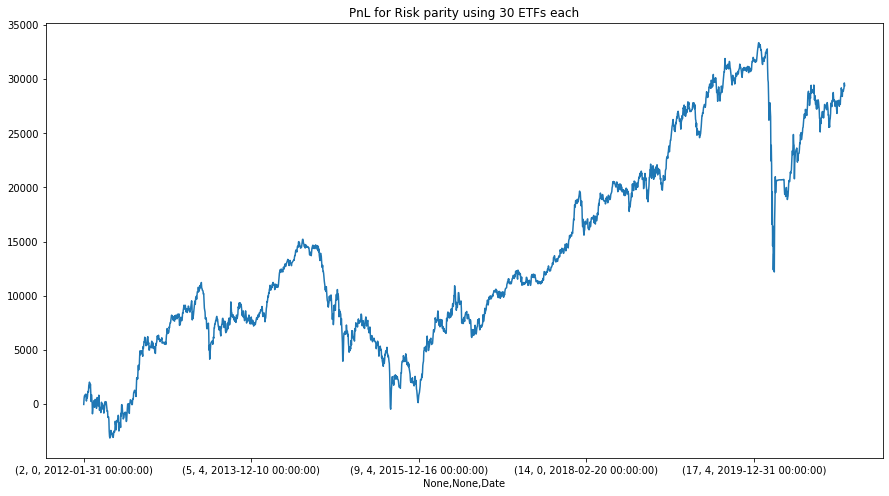

In [113]:
pd.concat(PnL_rp).cumsum().plot(figsize=(15,8))
plt.title('PnL for Risk parity using 30 ETFs each')
print(f'Max drawdown: {max_drawdown_rp}')
overallrisk_rp

Max drawdown: -271.4109404298448%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-342.800372,-466.321779,-413.708984,-512.885170
3,-464.000983,-569.431401,-557.303260,-696.482934
4,-1159.166604,-1841.648450,-1515.199283,-2125.094206
5,-761.413711,-1432.215340,-1116.184049,-1572.126810
6,-499.712953,-696.792873,-607.008728,-766.338481
7,-752.797453,-1396.109207,-1076.470404,-1457.126950
8,-545.694473,-845.988917,-705.703086,-884.049647
9,-1332.830059,-2725.043137,-1978.994465,-3109.303917
10,-1279.536943,-1731.845127,-1552.708696,-1793.541223


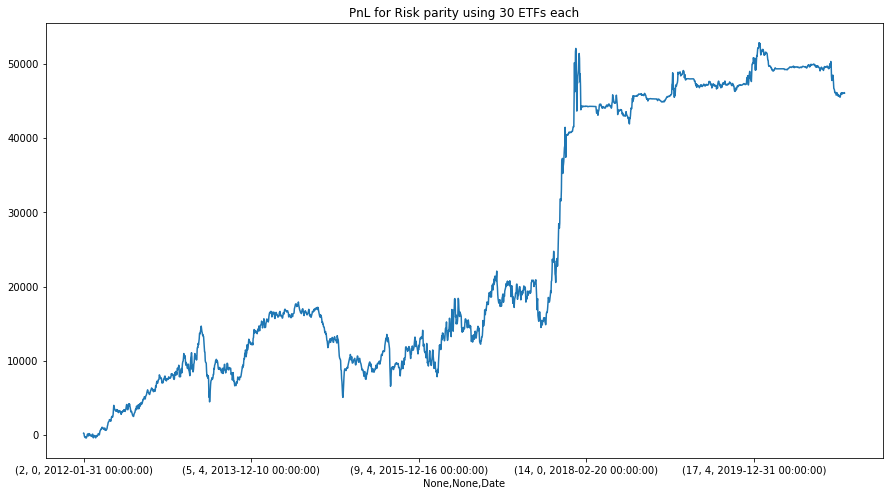

In [114]:
pd.concat(PnL_sr).cumsum().plot(figsize=(15,8))
plt.title('PnL for Risk parity using 30 ETFs each')
print(f'Max drawdown: {max_drawdown_sr}')
overallrisk_sr

Text(0.5, 1.0, 'For Risk parity using 10 ETFs each')

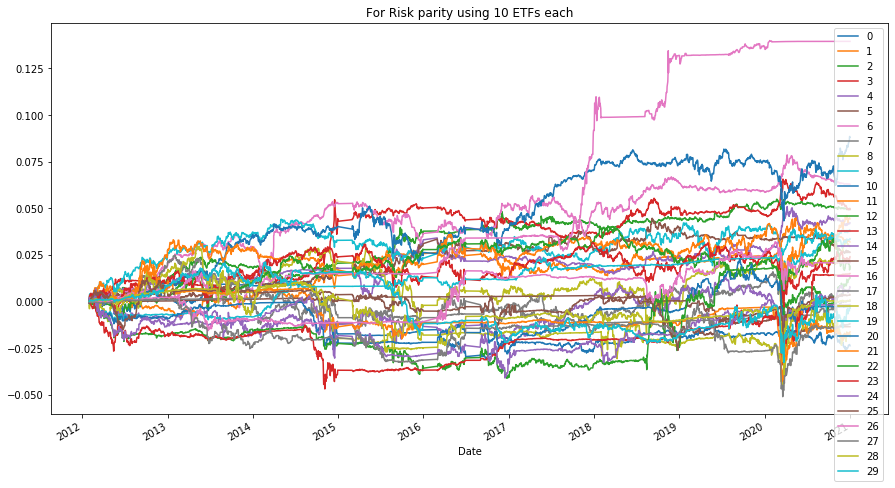

In [115]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.title('For Risk parity using 10 ETFs each')

Text(0.5, 1.0, 'For Risk parity using 10 ETFs each')

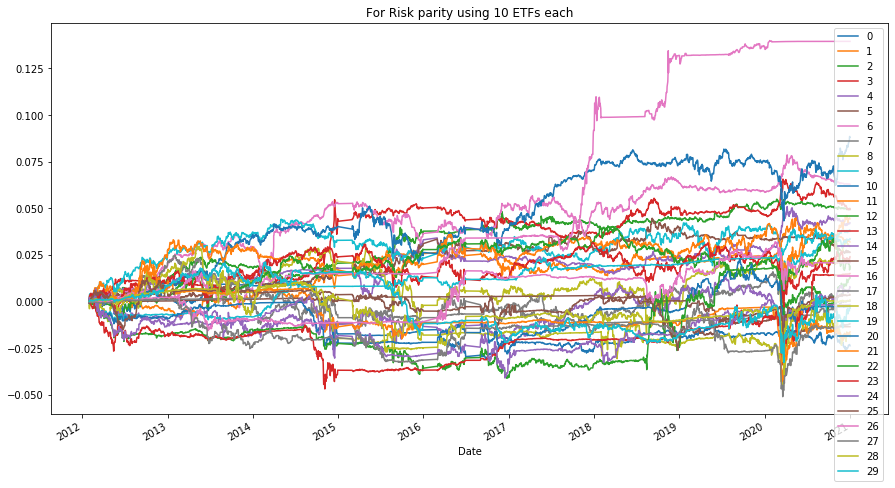

In [116]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.title('For Risk parity using 10 ETFs each')

Text(0.5, 1.0, 'For Sharpe Ratio Maximization using 10 ETFs each')

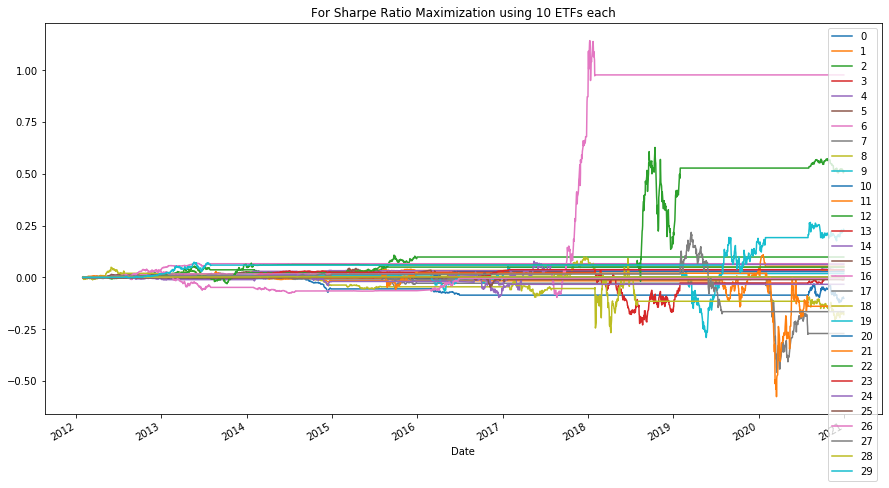

In [117]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.title('For Sharpe Ratio Maximization using 10 ETFs each')

30 cutoff ETFs

In [118]:
opt30 = portfolio_optimizer(semiannual)

# MVO:
pct_full_portfolio_mvo, dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo = opt30.portfolio_simulator(100000, riskfree, top30, 30,VaRcutoff, 'MVO')
# Risk parity
pct_full_portfolio_rp, dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt30.portfolio_simulator(100000, riskfree, top30, 30,VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
pct_full_portfolio_sr, dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt30.portfolio_simulator(100000, riskfree, top30, 30,VaRcutoff, 'Sharpe ratio maximization')

Max drawdown: -270.9191137410651%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-968.649132,-1513.447497,-1248.037943,-1524.209876
3,-542.989381,-947.355248,-765.317089,-983.542117
4,-901.040140,-1951.331617,-1499.253453,-2393.487402
5,-1019.833395,-1534.282293,-1294.484794,-1662.491464
6,-690.714205,-1121.904237,-958.335471,-1158.769349
7,-924.789372,-1217.746554,-1125.936523,-1366.799144
8,-814.046219,-1193.553380,-1041.214603,-1327.504761
9,-1177.148639,-2548.638478,-1817.834176,-2762.755652
10,-950.032563,-1644.366984,-1487.748042,-2314.780267


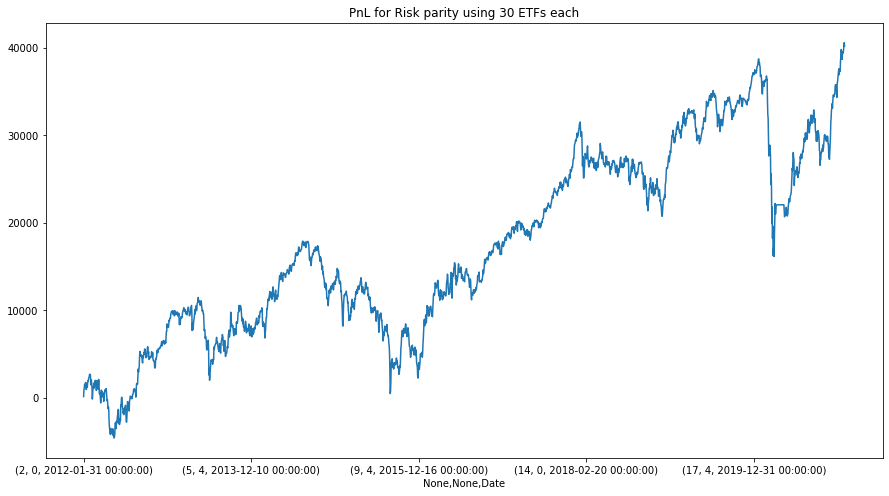

In [119]:
pd.concat(PnL_mvo).cumsum().plot(figsize=(15,8))
plt.title('PnL for Risk parity using 30 ETFs each')
print(f'Max drawdown: {max_drawdown_mvo}')
overallrisk_mvo

Max drawdown: -270.9168891914651%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-968.636818,-1513.433354,-1248.025920,-1524.194987
3,-542.987265,-947.352806,-765.315085,-983.539845
4,-901.039504,-1951.330024,-1499.252266,-2393.485246
5,-1019.830727,-1534.278705,-1294.480901,-1662.486923
6,-690.712225,-1121.902906,-958.333312,-1158.767443
7,-924.789117,-1217.745929,-1125.935541,-1366.797675
8,-814.044790,-1193.551305,-1041.212893,-1327.502604
9,-1177.148255,-2548.637019,-1817.833493,-2762.756650
10,-950.028087,-1644.361180,-1487.742734,-2314.773461


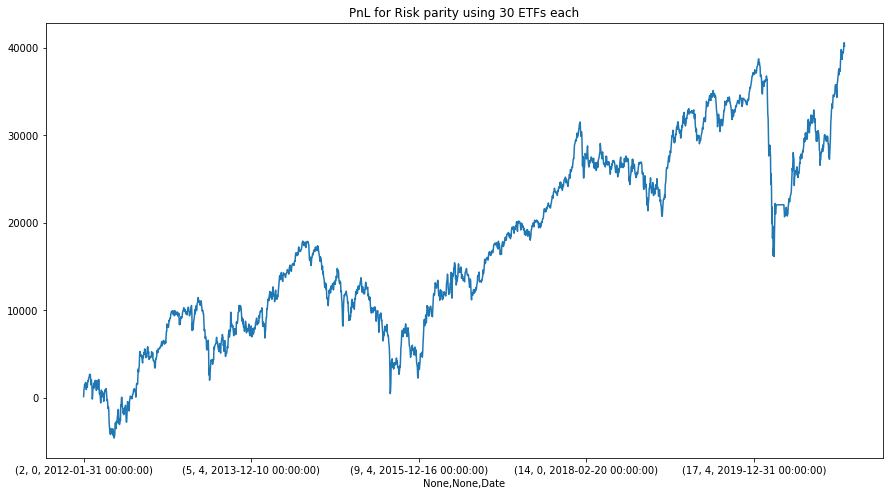

In [120]:
pd.concat(PnL_rp).cumsum().plot(figsize=(15,8))
plt.title('PnL for Risk parity using 30 ETFs each')
print(f'Max drawdown: {max_drawdown_rp}')
overallrisk_rp

Max drawdown: -349.32558939866453%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-326.158821,-452.231271,-393.655944,-472.345888
3,-393.087610,-522.193366,-480.097977,-589.070273
4,-1245.237367,-1787.238632,-1592.961824,-2181.740934
5,-687.912339,-1115.682740,-962.002036,-1313.264327
6,-492.549296,-646.238322,-587.369400,-703.810982
7,-555.843966,-1024.997263,-787.329589,-1138.598662
8,-521.364900,-785.105816,-663.789229,-806.754208
9,-982.736069,-1286.911033,-1238.113604,-1665.111021
10,-1042.641255,-1391.389702,-1230.924929,-1455.875128


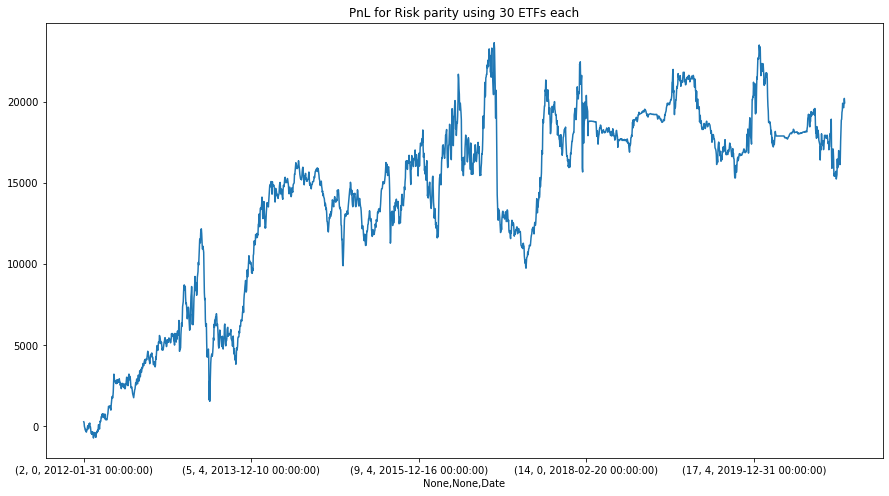

In [121]:
pd.concat(PnL_sr).cumsum().plot(figsize=(15,8))
plt.title('PnL for Risk parity using 30 ETFs each')
print(f'Max drawdown: {max_drawdown_sr}')
overallrisk_sr

Text(0.5, 1.0, 'For Risk parity using 10 ETFs each')

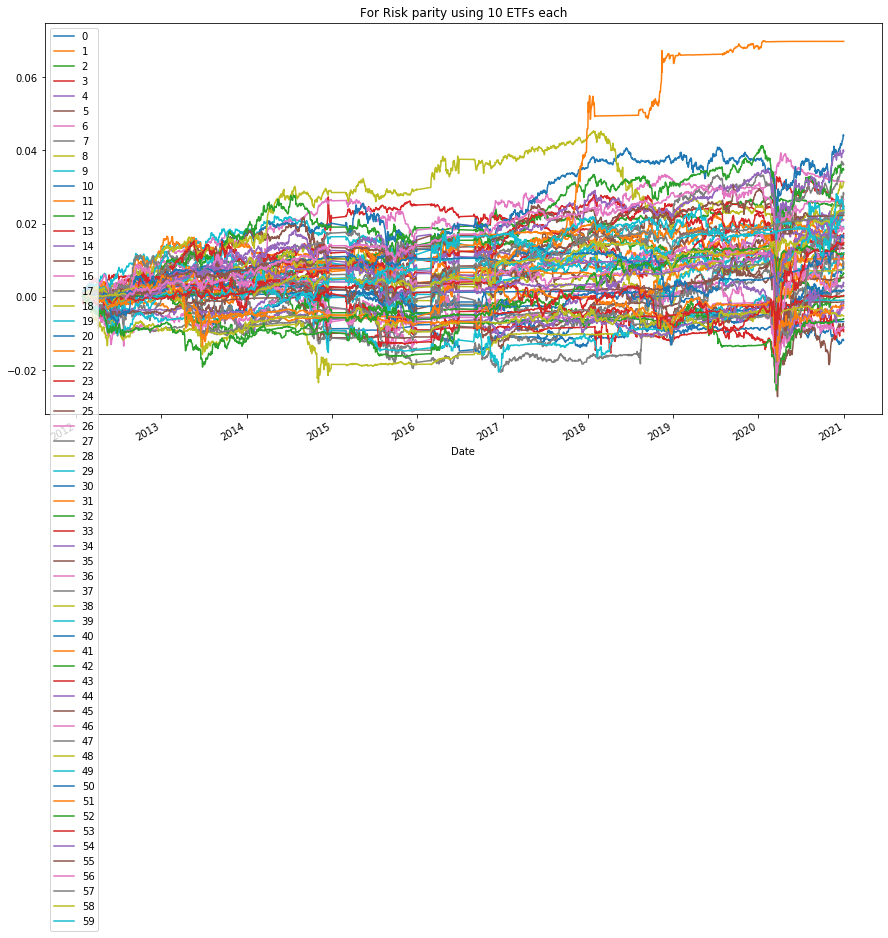

In [122]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.title('For Risk parity using 10 ETFs each')

Text(0.5, 1.0, 'For Risk parity using 10 ETFs each')

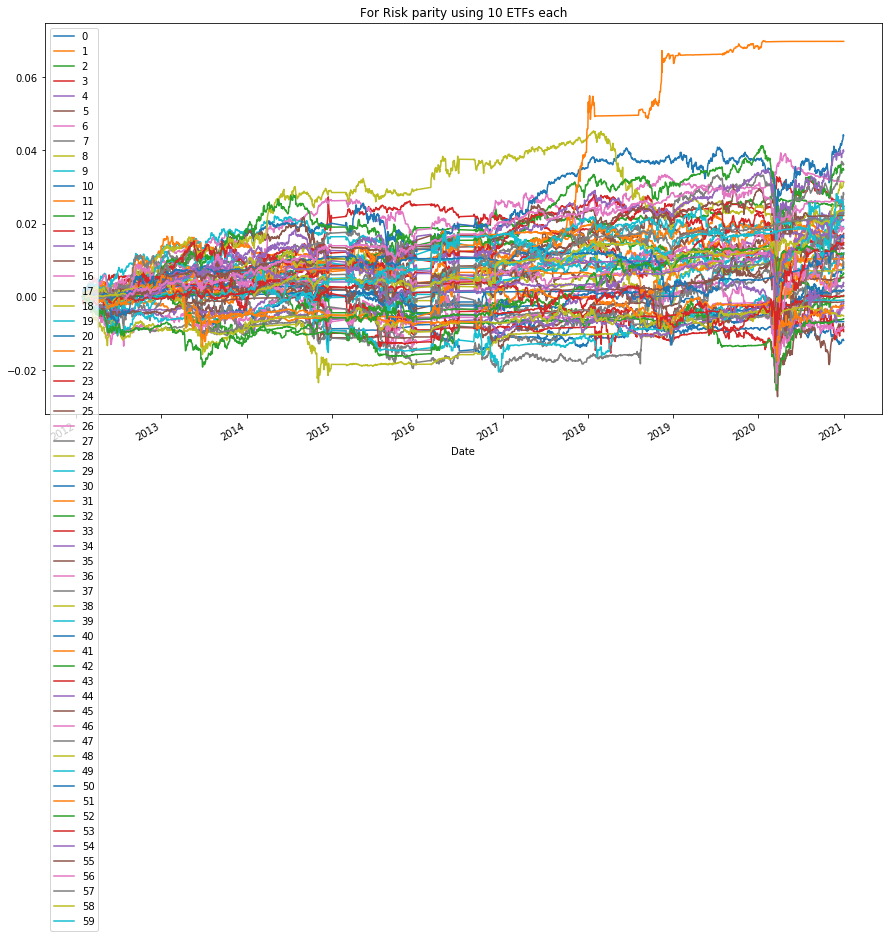

In [123]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.title('For Risk parity using 10 ETFs each')

Text(0.5, 1.0, 'For Sharpe Ratio Maximization using 10 ETFs each')

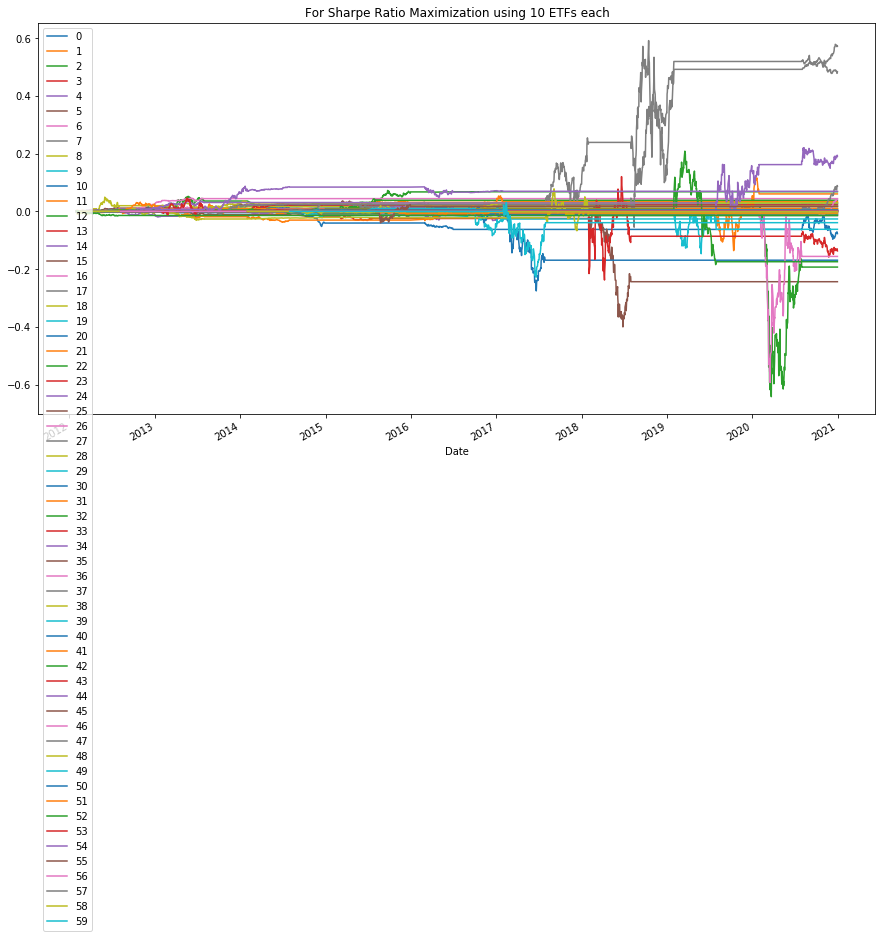

In [124]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.title('For Sharpe Ratio Maximization using 10 ETFs each')